### Úkol

Zadání tohoto úkolu prověřuje vaše pochopení látky probírané na cvičení. Jeho cílem je implementace __výpočtu nejkratší vzdálenosti mezi obdélníky__ na zadaném zdrojovém obrázku. Úkol má první __základní část s nápovědami__ a druhou __dobrovolnou část__ s bonusovými rozšířeními. __Maximální počet bodů za základní část je 5__, z bonusové části je možné získat až __2 prémiové__. Podrobnosti o bonusech jsou na konci notebooku. Pokud si s něčím nebudete dlouho vědět rady, napište email a domluvíme konzultaci.


Nyní uvažujme pouze základní variantu. Na začátek si je důležité uvědomit, že se __nejedná o vzdálenost mezi středy obdélníků__, nýbrž o nejkratší možné vzdálenosti hran objektů viz. [obrázek](text_imgs/patterns_lengths_example.JPG). Nezoufejte nyní, pokud nevíte jak vzdálenosti vypočítat, nápovědy v notebooku vám pomohou s řešením. Nemusíte se však striktně držet postupu, jakákoliv __individualita je vítaná__. K funkčnímu řešení se dá dobrat různými způsoby.

![](text_imgs/patterns_lengths_example.JPG)


Možná se ptáte, k čemu je to vlastně dobré. Motivace je ale jednoduchá - jedná se totiž o celkem běžně řešený problém v praxi. Navíc, v knihovně OpenCV pro to __neexistuje nativní implementace__, takže pokud zůstanete v oboru, může se vám to v budoucnu hodit. Představte si nyní, že vytváříte aplikaci, která má za úkol automatizovaně hrát hru ve které je nutné předcházet kolizím objektů ve scéně. Objekty umíte lokalizovat a ohraničit (nejčastěji obdélníkem), a mohou být různě velké a natočené. Jak nyní zjistit, jak jsou od sebe objekty daleko? V případě, že nebudou objekty (tedy ani obdélníky) natočené, lze vzdálenost vypočíst se znalostí středoškolské geometrie. V reálných situacích se tohle ale moc často nestává. Objekty jsou většinou libovolně natočené a tím se řešení trochu komplikuje. Stále si ale vystačíme se znalostí analytické geometrie ze střední školy, jen bude potřeba trochu programování navíc. Mimo kolize ve hře si můžeme představit využití i např. v aplikaci pro sledování pohybujících se objektů nebo monitorování průmyslových procesů (výrobní linka, spojování materiálů, atd.). 

Abychom si zbytečně nekomplikovali život, budeme řešení implementovat pouze na jednoduchém statickém snímku s několika obdélníky. __Zdrojový snímek základní verze je__ [patterns_photo_basic.jpg](patterns_photo_basic.jpg). Využijeme naší znalost ze cvičení a budou nás __zajímat nejkratší vzdálenosti v centimetrech__, nikoliv v pixelech.
![](text_imgs/patterns_thumb.jpg)

Předpokladem tohoto úkolu je, že __máte vypracovaný notebook z 3. cvičení__. Budeme totiž znovu potřebovat segmentované kontury všech objektů, a vzhledem k tomu, že už máme nějakou práci hotovou, byla by škoda na ni nenavázat. Využijeme tedy vypracovaný notebook ze cvičení, upravíme pouze barevné intervaly ve funkcích `inRange()` tak, aby dávaly smysl pro nový zdrojový obrázek. 

Na konec vyplněného notebooku ze cvičení rafinovaně __napojíme všechny buňky tohoto notebooku__. Nejjednoduší způsob jak to navázat je: 
* Pro jistotu si zálohovat původní notebook (pokud ho nemáte na gitu, fakt to udělejte).
* Zkopírovat si potřebné zdrojové obrázky do stejné složky.
* Otevřít si tento notebook a notebook ze cvičení v textovém editoru.
* Všimněte si poměrně jednoduché struktury souboru ipynb notebooků. Jedná se o klasický formát JSON. Všechny buňky souboru se nachází v `{ "cells": [....] }`.
* Obsah struktury `"cells"` zkopírujeme a vložíme na konec seznamu `"cells"` v souboru ze cvičení. Dejte si pozor ať vám sedí čárky a uzavírací závorky "]".

### Základní část

In [1]:
%run ./library.ipynb

In [2]:
import itertools
import math
import cv2

from improutils import *

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

V řešení ze cvičení už máme hotové segmentace referenčního i ostatních objektů uložené formou kontur. 
Všechny tyto kontury se vyplatí přemístit do jedné struktury, neboť se s ní následně bude lépe pracovat.

__1) Přesuňte všechny kontury do jedné struktury (např. list).__

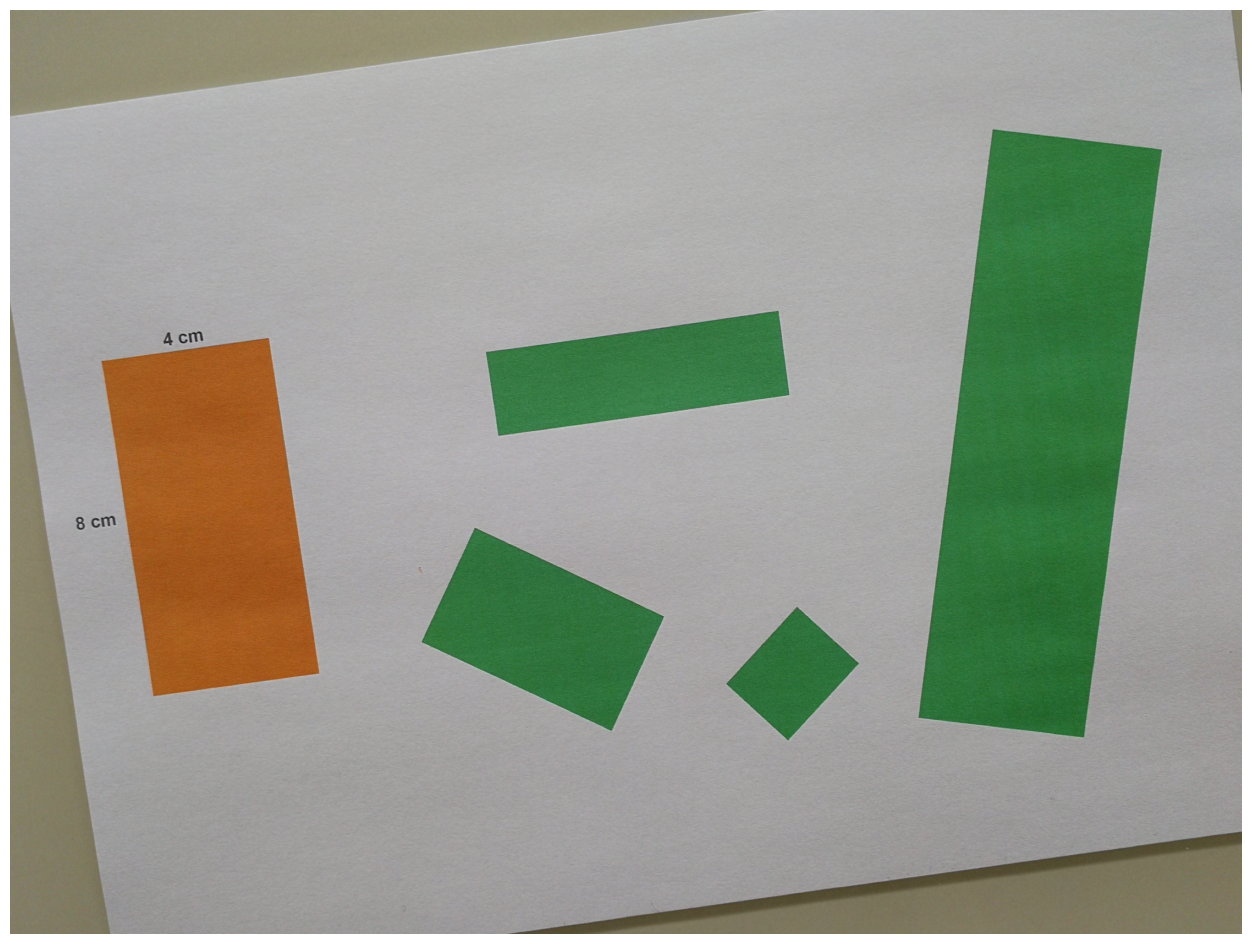

In [3]:
image = load_image("patterns_photo_basic.jpg")
plot_images(image)

In [4]:
ref_width_real = 4
ref_height_real = 8
from ipywidgets import *

In [5]:
@interact(h_range=create_slider(min=0, max=255, description='Hue:'),
          s_range=create_slider(min=0, max=255, description='Saturation:'),
          v_range=create_slider(min=0, max=255, description='Value:'))
def _(h_range, s_range, v_range):

    lower_bound = (h_range[0], s_range[0], v_range[0])
    upper_bound = (h_range[1], s_range[1], v_range[1])
    
    mask = segmentation_two_thresholds(image,lower_bound,upper_bound) ###
    plot_images(mask, apply_mask(image, mask))

interactive(children=(IntRangeSlider(value=(0, 255), continuous_update=False, description='Hue:\xa0\xa0\xa0\xa…

In [6]:
known_cube_upper_bound = (to_intensity(101), 115, 209)
known_cube_lower_bound = (to_intensity(0), 0, 135)

others_ub = (127, 137, 99)
others_lb = (0, 91, 0)

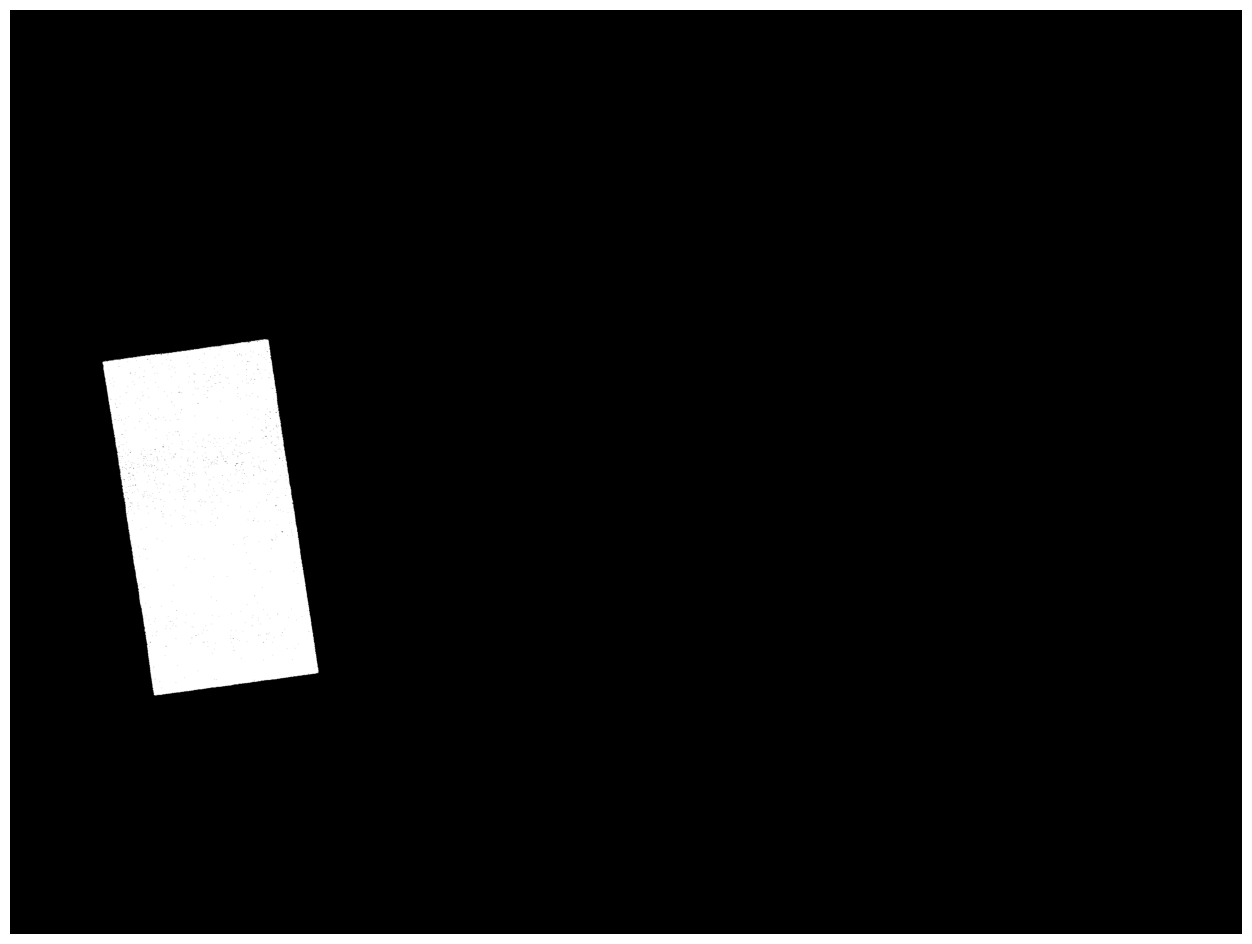

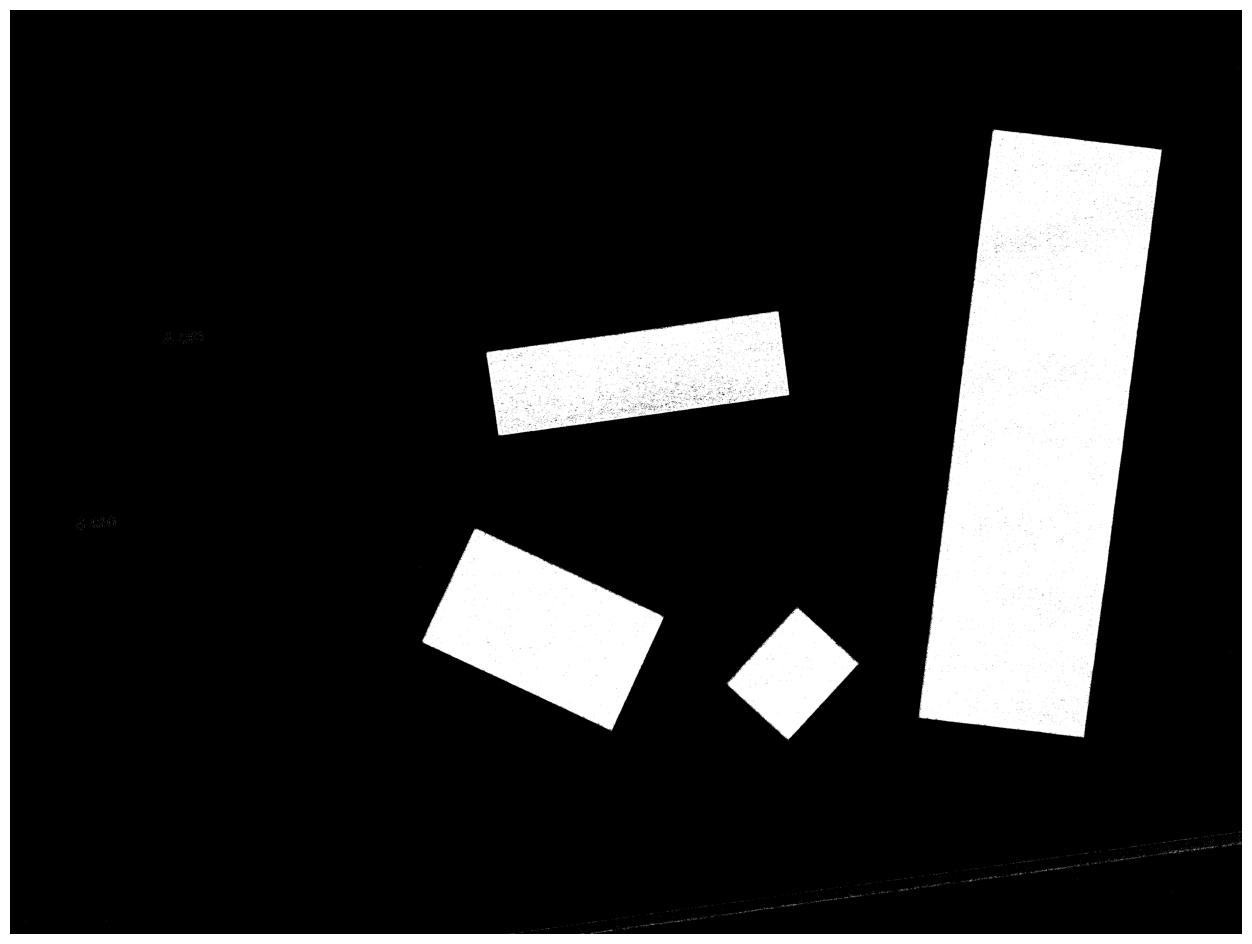

In [7]:
mask_first = segmentation_two_thresholds(image, known_cube_lower_bound, known_cube_upper_bound)
mask_others = segmentation_two_thresholds(image, others_lb, others_ub)
plot_images(mask_first)
plot_images(mask_others)

Found 1091 contours.
After filtering, 1 contours remained.


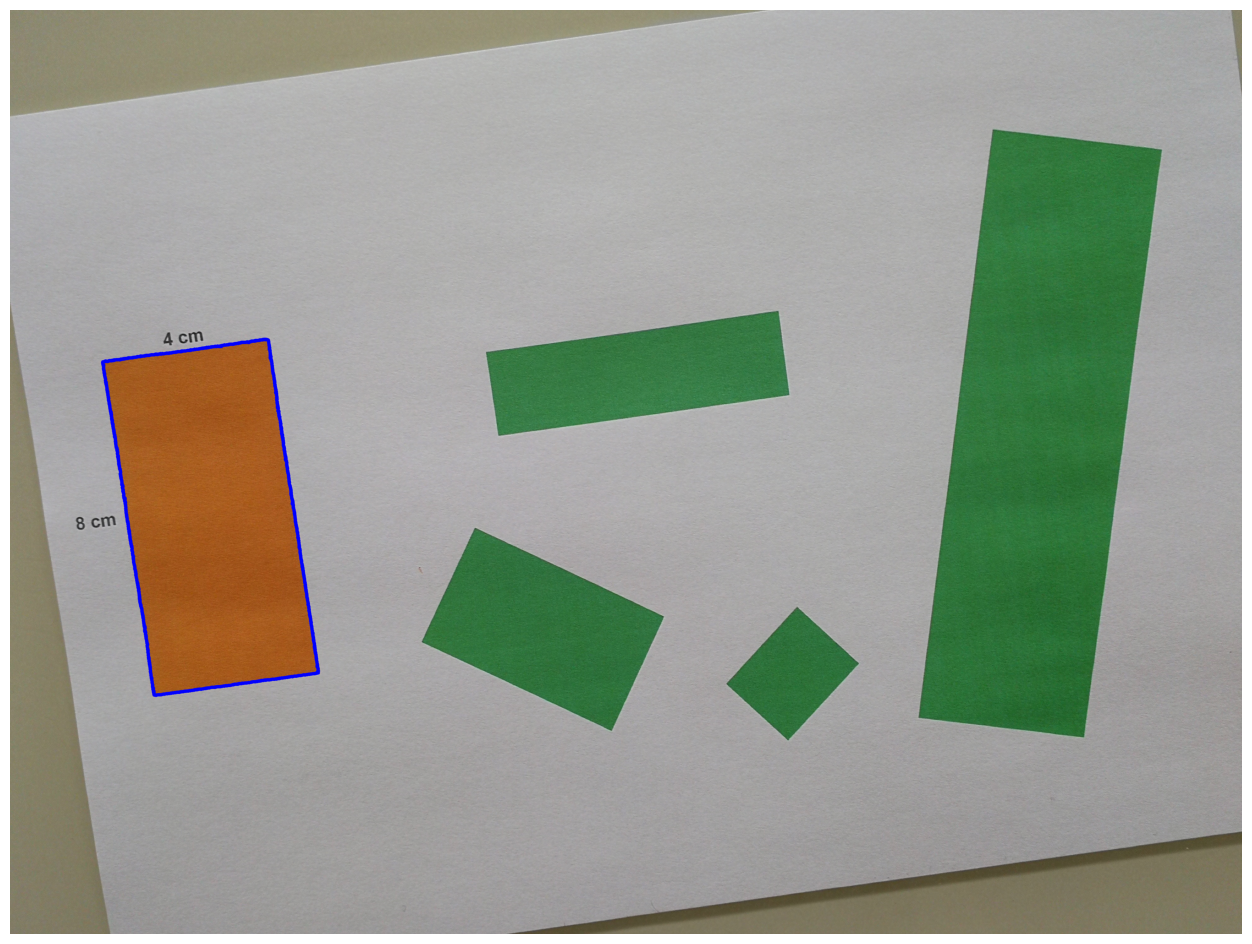

In [8]:
_, num_contours, contours = find_contours(mask_first, external=False)
print(f'Found {num_contours} contours.')

# Filter out noise
threshold = 2000 ###
contours_first =  [c for c in contours if cv2.contourArea(c) > threshold]
print(f'After filtering, {len(contours_first)} contours remained.')

contours_img = cv2.drawContours(image.copy(), contours_first, -1, color=(255, 0, 0 ), thickness=10)
plot_images(contours_img)

Found 6705 contours.
After filtering, 4 contours remained.


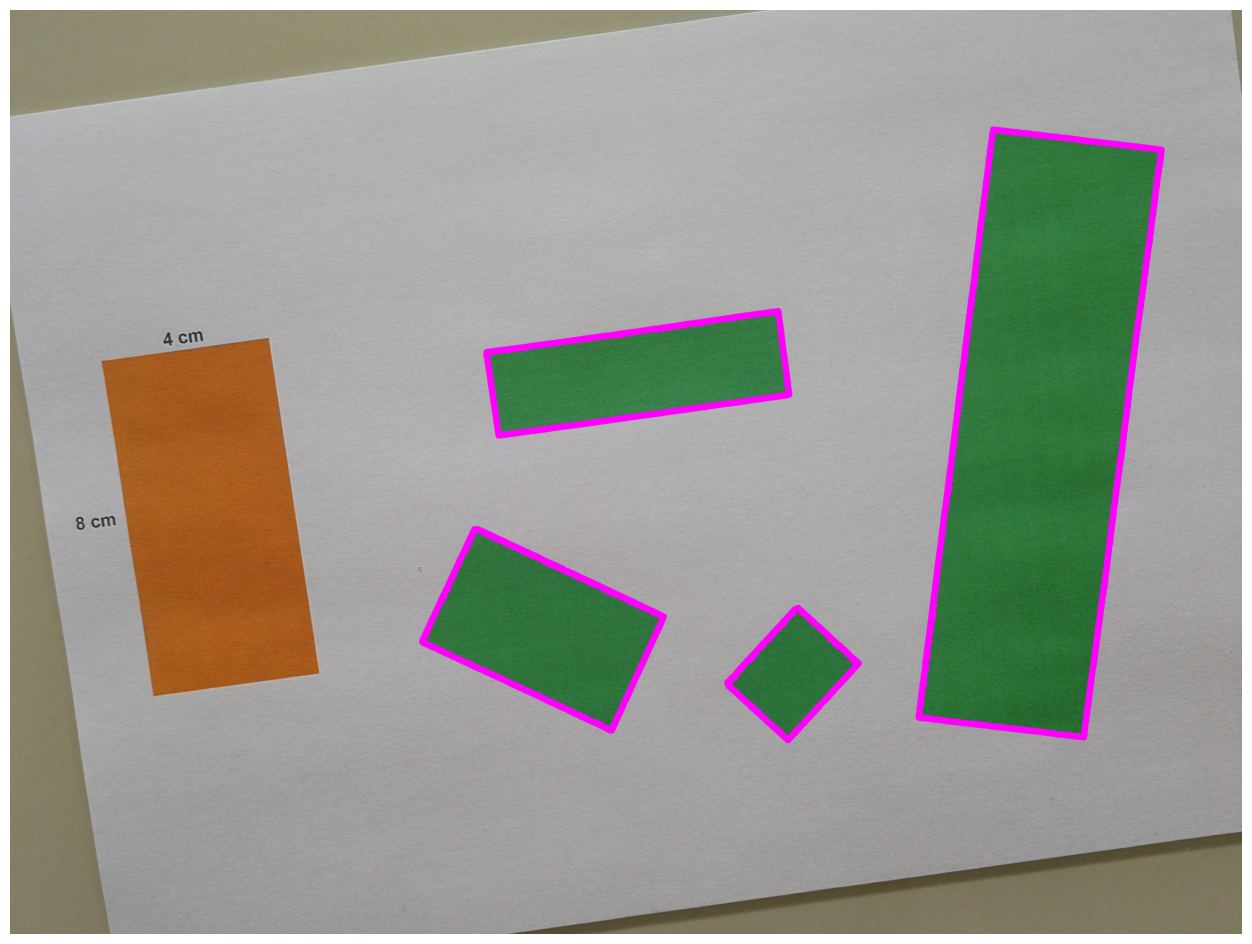

In [9]:
_, num_contours, contours = find_contours(mask_others, external=False, max_area=10000000000000000)
print(f'Found {num_contours} contours.')

# Filter out noise
threshold = 100 ###
contours_others =  [c for c in contours if cv2.contourArea(c) > threshold]
print(f'After filtering, {len(contours_others)} contours remained.')

contours_img = cv2.drawContours(image.copy(), contours_others, -1, color=(255, 0, 255 ), thickness=20)
plot_images(contours_img)

In [10]:
contours = contours_first.copy()
contours.extend(contours_others)

__2) Pomocí funkce `len()` ověřte, že jich máte správný počet.__

In [11]:
len(contours)

5

__3) Uložte si hodnoty všech možných indexů předchozího listu do nového listu. Může se vám k tomu hodit funkce `range()` + `list()`. Ideálně využijte i předchozí informaci o počtu kontur.__

In [12]:
all_indexes = list(range(len(contours)))
print(all_indexes)

[0, 1, 2, 3, 4]


__4) Využijte funkci `itertools.combinations()` k získání všech možných dvojic kombinací indexů kontur. Pro jistotu si je vypiště.__

In [13]:
combinations = list(itertools.combinations(all_indexes , 2))
print(combinations)

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


Nyní už to konečně začne být trochu zajímavé. Zbývá __projít všechny možné kombinace kontur, aproximovat je obdélníkem
vypočítat vzdálenost mezi všemi obdélníky, a výsledek vhodně vizualizovat v reálných jednotkách__. 
To je na jednu Jupyter buňku až moc operací, lepší řešení tedy bude tyto kroky rozpadnout do několika funkcí.

Způsobů výpočtu nejkratší vzdáleností mezi obdelníky je více. Můžete samozřejmě využít jakékoliv řešení budete chtít (za předpokladu korektnosti výsledků). V tomto postupu budem však uvažovat pouze jedno a to, které se nám zdálo nejjednoduší na pochopení. 

Pro zjedodnušení celé úlohy __není nutné uvažovat žádné složité speciální případy__ - nejsme Progtest. Nemusíte tedy uvažovat, že se tvary jakkoliv překrývají. Předpokládáme, že vzdálenost je vždy > 0. S tím také souvisí pozdější detaily jako __neřešení případů bodu ležícího na úsečce, úsečky se protínají, atd__.

Začneme tedy prvním stavebním kamenem našeho algoritmu, tedy __funkcí, která vypočte vzdálenost bodu od úsečky v pixelech__. Tato funkce je jádrem celého našeho řešení, je tedy nutné si ověřit, že vrací správné hodnoty.

Pokud vůbec netušíte, jak byste takovou věc implementovali, hledejte klíčová slova `"distance between line segment and point"` a inspirujte se. Nezapomeňte však __uvést zdroj__ + případne okomentování. __Dejte si pozor, že line segment != line__, pracujeme pouze s úsečkami.

__5) Doplňte funkci pro výpočet vzdálenosti mezi úsečkou a bodem.__

In [14]:
import math
def is_in_line_segment(l_pt1, l_pt2, unknown_pt):
    if len(l_pt1) != len(l_pt2) or len(l_pt1) != len(unknown_pt):
        raise ValueError("Vectors are not of the same size")
    # looks if the point is inbetween the two points in each dimension
    for i in range(len(l_pt1)):
        top = max(l_pt1[i], l_pt2[i])
        bottom = min(l_pt1[i], l_pt2[i])
        middle = unknown_pt[i]
        if middle > top or middle < bottom:
            return False
    return True

def dist(pt1, pt2):
    return np.abs(np.linalg.norm(pt1 - pt2))

def line_segment_to_point_dist(l_pt1, l_pt2, dst_pt):
    
    # convert to numpy arrays
    line_point1 = np.asarray(l_pt1)
    line_point2 = np.asarray(l_pt2)
    destination = np.asarray(dst_pt)
    
    # move the space, so the line is subspace of a two dimensional space
    line_point2 -= line_point1
    destination -= line_point1
    line_point1 -= line_point1
    
    # get line vector
    l_vec = line_point2 - line_point1
    # get vector perpendicular to the line
    l_norm = np.asarray([l_vec[1], -l_vec[0]])
    
    # using these 
    #dst_pt[0] = a * l_vec[0] + b * l_norm[0]
    #dst_pt[1] = a * l_vec[1] + b * l_norm[1]
    
    #setting up matrix for gauss method
    a = np.array([l_vec, l_norm])
    a = np.transpose(a)
    b = destination

    solution = np.linalg.solve(a, b)
    # get point of the line, from which the perpendicular line runs
    strike = line_point1 + solution[0] * l_vec
    # if the perpendicular line, really strikes the line
    # calculate distance as length of the perpend. line
    if is_in_line_segment(line_point1, line_point2, strike):
        return np.abs(solution[1] * np.linalg.norm(l_norm))
    
    
    dst1 = dist(destination, line_point1)
    dst2 = dist(destination, line_point2)

    return min(dst1, dst2)
    

__6) Otestujte, že funkce vrací správné výsledky a dopište alespoň dva další asserty.__

In [15]:
assert line_segment_to_point_dist((1,3), (3,4), (4,4)) ==  1
assert line_segment_to_point_dist((1,3), (3,4), (3,4)) == 0
assert line_segment_to_point_dist((3,4), (1,3), (4,4)) == 1
assert line_segment_to_point_dist((1,3), (3,4), (2, 3.5)) == 0

Nyní potřebujeme další stavební blok, a to nejkratší vzdálenost dvou úseček. K tomu využijeme už hotovou funkci `line_segment_to_point_dist()`. Pokud vás nenapadá jak, zkuste si to nakreslit na papír.
Nezapomeňte, že __nemusíme uvažovat speciální případy__ (např. to, že se protínají). S využítím funkce `min()` je to dokonce pouze na jeden řádek kódu.

__7) Doplňte funkci pro výpočet vzdálenosti mezi dvěmi úsečkami.__

In [16]:
def line_segments_dist(l1_pt1, l1_pt2, l2_pt1, l2_pt2):
    distances = []
    distances.append(line_segment_to_point_dist(l1_pt1, l1_pt2, l2_pt1))
    distances.append(line_segment_to_point_dist(l1_pt1, l1_pt2, l2_pt2))

    distances.append(line_segment_to_point_dist(l2_pt1, l2_pt2, l1_pt1))

    distances.append(line_segment_to_point_dist(l2_pt1, l2_pt2, l1_pt2))
    return min(distances)

__8) Otestujte, že funkce vrací správné výsledky a dopište alespoň dva další asserty.__

In [17]:
assert line_segments_dist((1,3), (3,4), (5,7), (5,1)) ==  2
assert line_segments_dist((1,5), (6,5), (7,7), (7,5)) == 1
assert line_segments_dist((1,5), (6,5), (6,5), (1,5)) == 0
assert line_segments_dist((1,5), (6,5), (2,5), (3,5)) == 0

Když už umíme vypočítat nejkratší vzdálenost dvou úseček, máme vše potřebné pro výpočet nejkratší vzdálenosti mezi dvěma obdélníky. Stačí si jen uvědomit, že obdélník je složen ze čtyř spojených úseček. 

Typ vstupních parametrů funkce `rect_dist` je na vás. Nezapomeňte však, že `cv2.minAreaRect()` nevrací přímo souřadnice rohových bodů. Připomeňte si `cv2.boxPoints()` a `order_points()`.

__9) Doplňte funkci pro výpočet vzdálenosti mezi dvěma obdélníky.__

In [18]:
import cv2

def rect_dist(r1_pts, r2_pts):
    distances = []
    length1 = len(r1_pts)
    length2 = len(r2_pts)
    for i in range(length1):
        for j in range(length2):
            distances.append(line_segments_dist(tuple(r1_pts[i]),
                                                tuple(r1_pts[(i + 1) % length1]),
                                                tuple(r2_pts[j]),
                                                tuple(r2_pts[(j + 1) % length2])))
    return min(distances)

__10) Otestujte, že funkce vrací správné výsledky a dopište alespoň dva další asserty.__

In [19]:
assert rect_dist(((1,5), (6,5), (6,3), (1,3)), ((7,7), (9,7), (9, 5), (7, 5))) == 1
assert rect_dist(((1,5), (6,5), (6,3), (1,3)), ((4,10), (6, 8), (4, 6), (2,8))) == 1
assert rect_dist(((1,5), (6,5), (6,3), (1,3)), ((7,7), (9,7), (9, 5), (7, 5))) == rect_dist(((7,7), (9,7), (9, 5), (7, 5)), ((1,5), (6,5), (6,3), (1,3)))
assert rect_dist(((1,5), (6,5), (6,3), (1,3)), ((1,5), (6,5), (6,3), (1,3))) == 0

Blížíme se do finále. Úplně v první buňce tohoto úkolu bychom měli mít vytvořený list se všemi konturami a list všech dvojic kombinací indexů kontur. Kontury vhodně převeďte tak, aby je bylo možné předat do definované funkce `rect_dist()` a tím získat vzdálenost mezi dvěma obdélníky v pixelech. Následně přepočítejte pixely na skutečné jednotky a vypiště nalezené vzdálenosti ve vhodném a kontrolovatelném formátu (např.: 1 <-> 3: 2.2 cm). 

__11) Vypočítejte vzdálenosti mezi všemi obdélníky ve snímku, vypiště vzdálenosti ve vhodném formátu v centimetrech.__

In [20]:
rect = cv2.minAreaRect(contours_first[0])
pts = cv2.boxPoints(rect)
width_pt = (dist(pts[0], pts[1]) + dist(pts[2], pts[3])) / 2
height_pt = (dist(pts[1], pts[2]) + dist(pts[3], pts[0])) / 2

width_cm = 4
height_cm = 8

# conversion ratio is taken as a wighted average of all conversion ratios we can calculate
pt_to_cm = 2/3 * 8 / height_pt + 1/3 * 4 / width_pt

In [21]:
for index, comb in enumerate(combinations):
    rect1 = cv2.minAreaRect(contours[comb[0]])
    rect2 = cv2.minAreaRect(contours[comb[1]])
    pts1 = cv2.boxPoints(rect1)
    pts2 = cv2.boxPoints(rect2)
    distance = rect_dist(cv2.boxPoints(rect1), cv2.boxPoints(rect2))
    print("{} -> {}: {}".format(index, comb, np.round(distance * pt_to_cm, 2)))

0 -> (0, 1): 9.61
1 -> (0, 2): 2.5
2 -> (0, 3): 5.01
3 -> (0, 4): 14.17
4 -> (1, 2): 1.97
5 -> (1, 3): 4.96
6 -> (1, 4): 1.54
7 -> (2, 3): 2.22
8 -> (2, 4): 6.22
9 -> (3, 4): 3.95


### Bonusová část

Pokud to pro vás byla doposuď zívačka, a chtěli byste nějaké body navíc, je možné získat až 2 prémiové body za trochu dalšího přemýšlení a programování. Za každý splněný úkol ze seznamu je __1 prémiový bod__. Maximálně je možné získat __až 2 prémiové__.

#### Úkoly:
1) Vytvořte vhodnou vizualizaci vzdáleností mezi objekty. Např. vykreslení nejkratší úsečky mezi obdélníky a vypsání její délky v centimetrech.

2) Upravte váš algoritmus tak, aby korektně fungoval i pro obrázek `patterns_photo_bonus.jpg`. Tedy podpora výpočtu nejkratší vzdálenosti mezi kombinací tvarů obdélník a kružnice. Jiné elipsové tvary pro jednoduchost neuvažujte. Může se vám na to hodit `cv2.fitEllipse()`.

3) Zkuste navrhnout jiné řešení než to využívající vzdálenost bodů od úsečky. Nemusí být 100% funkční ve všech případech, ale jasně vyspecifikujte jeho úskalí a případy kdy nebude fungovat.